In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import os
import pickle
import time
# import shap
# import seaborn as sns

%load_ext autoreload
%autoreload 2

This notebook visualizes the from SHAP values inferred feature importance

In [2]:
from convection_param.HelperFuncs import unique_unsorted

data_path = '../../local_data/TrainData/20230131-171851-R2B5_y13y16_vcg-fluxes_rho_fluct.npz'
# data_path = '../../local_data/TrainData/20230210-131835-R2B5_y13y16_vcg-fluxes_rho_fluct_neglect.npz'
data = np.load(data_path)
print(data.files)

X_expl, Y_expl = data['X_expl'], data['Y_expl']

# vars_to_neglect_mask = ~np.isin(unique_unsorted([e[0] for e in X_expl]), vars_to_neglect)
# print(vars_to_neglect_mask)
vars_to_neglect = ['qr','qs']
X_expl_woqrqs = np.array([e for e in X_expl if e[0] not in vars_to_neglect])

['X_train', 'X_val', 'X_test', 'Y_train', 'Y_val', 'Y_test', 'X_expl', 'Y_expl', 'train_coords', 'val_coords', 'test_coords']


In [3]:
X_expl_vars = [v[0] for v in X_expl]
X_expl_vars_woqrqs = [v[0] for v in X_expl_woqrqs]
Y_expl_vars = [v[0] for v in Y_expl]

Y_uniq_vars, Y_uniq_idx = np.unique(Y_expl_vars, return_index=True)
idx_sorted = np.argsort(Y_uniq_idx)
Y_uniq_vars = Y_uniq_vars[idx_sorted]
Y_uniq_idx = Y_uniq_idx[idx_sorted]

X_uniq_vars, X_uniq_idx = np.unique(X_expl_vars, return_index=True)
idx_sorted = np.argsort(X_uniq_idx)
X_uniq_vars = X_uniq_vars[idx_sorted]
X_uniq_idx = X_uniq_idx[idx_sorted]

X_uniq_vars_woqrqs, X_uniq_idx_woqrqs = np.unique(X_expl_vars_woqrqs, return_index=True)
idx_sorted_woqrqs = np.argsort(X_uniq_idx_woqrqs)
X_uniq_vars_woqrqs = X_uniq_vars_woqrqs[idx_sorted_woqrqs]
X_uniq_idx_woqrqs = X_uniq_idx_woqrqs[idx_sorted_woqrqs]

In [4]:
def get_saved_shap_values(path, classic_ml):
    model_path_content = list(os.scandir(path))

    X_explains = []
    backgrounds = []
    shaps = []
    shap_files = [c.path for c in model_path_content if 'shaps_' in c.name]
    for f in tqdm(shap_files):
        data = np.load(f)
        X_explains.append(data['X_explain'])
        shaps.append(data['shap_values'])

    X_explains = np.stack(X_explains, axis=0)
    shaps = np.stack(shaps, axis=0)
    
    if classic_ml:
        # For classic ml data:
        X_explains_new_shape = list(X_explains.shape)[:-1] + [-1, 23]
        X_explains = X_explains.reshape(X_explains_new_shape)
        shaps_new_shape = list(shaps.shape)[:-1] + [-1, 23]
        shaps = shaps.reshape(shaps_new_shape)
    
    X_explains = np.swapaxes(X_explains, 0, 1)
    shaps = np.moveaxis(shaps, 0, 2)
    
    multiplier = X_explains - np.mean(X_explains, axis=0)
    multiplier /= np.maximum(np.max(np.abs(multiplier), axis=0), 0)
    
    shap_values3d = shaps[:-5,...]
    rshape = shap_values3d.shape
    rshape = [-1, 23] + list(rshape)[1:]
    shap_values3d = shap_values3d.reshape(rshape)
    
    print(multiplier.shape)
    print(shap_values3d.shape)
    shap_values3d = shap_values3d[:,::-1,:,:,:,::-1]
    multiplier = multiplier[:,:,:,::-1]
    return shap_values3d, multiplier

In [5]:
model_path = '../../Models/NewFormat/Torch/20230415-021732R2B5_vlr_unet_adam_lr0.0003_y13y16full_fluxes_prescaledeps1_wqrqstend_worhoprestemp_torch_rhofluct_alldays_hpoed/'
model_path_woqrqs = '../../Models/NewFormat/Torch/20230510-012946R2B5_vlr_unet_adam_lr0.0003_y13y16full_fluxes_prescaledeps1_wqrqstend_worhoprestemp_torch_rhofluct_alldays_woqrqs_hpoed/'

shap_values3d, multiplier = get_saved_shap_values(model_path, classic_ml=False)
mean_shap_values3d = np.mean(multiplier * shap_values3d, axis=2)
shap_importance3d = np.mean(np.abs(shap_values3d), axis=(0,1,2))

shap_values3d_woqrqs, multiplier_woqrqs = get_saved_shap_values(model_path_woqrqs, classic_ml=False)
mean_shap_values3d_woqrqs = np.mean(multiplier_woqrqs * shap_values3d_woqrqs, axis=2)
shap_importance3d_woqrqs = np.mean(np.abs(shap_values3d_woqrqs), axis=(0,1,2))

  0%|          | 0/5 [00:00<?, ?it/s]

(1000, 5, 9, 23)
(8, 23, 1000, 5, 9, 23)


  0%|          | 0/5 [00:00<?, ?it/s]

(1000, 5, 7, 23)
(8, 23, 1000, 5, 7, 23)


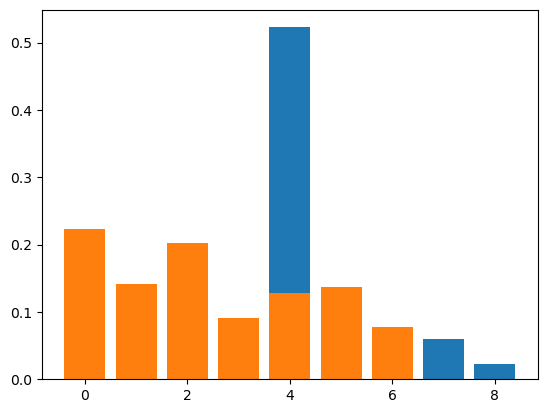

In [6]:
mean_shap_importance3d = shap_importance3d.mean(axis=0)
std_shap_importance3d = shap_importance3d.std(axis=0)
shap_importance_fract_test = np.sum(mean_shap_importance3d, axis=-1)/np.sum(mean_shap_importance3d)

mean_shap_importance3d_woqrqs = shap_importance3d_woqrqs.mean(axis=0)
std_shap_importance3d_woqrqs = shap_importance3d_woqrqs.std(axis=0)
shap_importance_fract_woqrqs_test = np.sum(mean_shap_importance3d_woqrqs, axis=-1)/np.sum(mean_shap_importance3d_woqrqs)

plt.bar(range(len(shap_importance_fract_test)), shap_importance_fract_test)
plt.bar(range(len(shap_importance_fract_woqrqs_test)), shap_importance_fract_woqrqs_test)
plt.show()

/tmp/ipykernel_1116909/1955128332.py:1: RuntimeWarning: invalid value encountered in divide
  plt.bar(range(len(mean_shap_importance3d_woqrqs.ravel())), std_shap_importance3d_woqrqs.ravel()/mean_shap_importance3d_woqrqs.ravel())


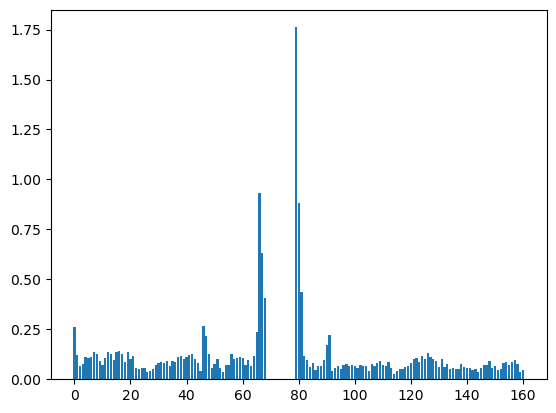

In [7]:
plt.bar(range(len(mean_shap_importance3d_woqrqs.ravel())), std_shap_importance3d_woqrqs.ravel()/mean_shap_importance3d_woqrqs.ravel())
# plt.bar(range(len(shap_importance_fract_woqrqs_test)), shap_importance_fract_woqrqs_test)
plt.show()

In [8]:
def round_series_retain_integer_sum(xs):
    N = sum(xs)
    Rs = np.round(xs)
    K = int(N - sum(Rs))
    if K > 0:
        fs = xs - Rs
        indices = np.argsort(fs)[-K:]
        Rs[indices] += 1
    return Rs

In [9]:
mean_shap_importance3d_woqrqs.sum()

1.6190893722218176

[0.08957695 0.05213482 0.06186812 0.03354592 0.52286378 0.10410771
 0.05275801 0.0598354  0.02330929]
[(9.0, 8.957694645233595), (5.0, 5.213482004105482), (6.0, 6.186811981063222), (3.0, 3.354591776914711), (52.0, 52.28637773620369), (11.0, 10.410770947389326), (5.0, 5.275801209640583), (6.0, 5.983540246531792), (2.0, 2.330929452917594)]
Sum: 99.0
[0.22310633 0.1419642  0.20264868 0.09086414 0.1279045  0.1364381
 0.07707404]
[(22.0, 22.310633306088246), (14.0, 14.196420426621916), (20.0, 20.264868446107684), (9.0, 9.0864142517588), (13.0, 12.790449573425096), (14.0, 13.643810408339455), (8.0, 7.707403587658794)]
Sum: 100.0


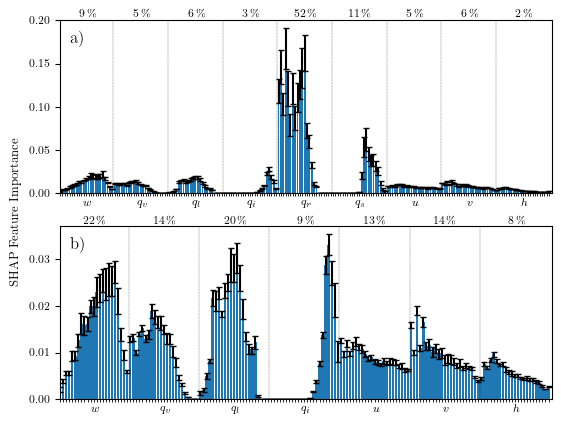

In [10]:
from convection_param.setup_mpl_tex import set_size, setup_mpl_tex, get_ax_size
from convection_param.Constants import input_var_remapping
import string

setup_mpl_tex()
# plt.style.use('default')

fig, axs = plt.subplots(2,1,constrained_layout=True, figsize=set_size('textwidth'))
(ax1, ax2) = axs
decimals = 0
plot_decimals = None if decimals == 0 else decimals

def plot_bar(mean_shap_importance, std_shap_importance, ax, X_ticks, X_tick_labels, retain_round_sum):
    shapshape = mean_shap_importance.shape
    x_ext = shapshape[0]*shapshape[1]
    X_tick_labels = [input_var_remapping[lab] for lab in X_tick_labels]
    plot_diff = 0.5
    x_tick_offset = 23/2

    shap_importance_mean = mean_shap_importance.flatten()
    shap_importance_std = std_shap_importance.flatten()
    ax.bar(range(len(shap_importance_mean)), shap_importance_mean, yerr=shap_importance_std, capsize=2)
    # ax.bar(range(len(shap_importance_mean)), np.divide(shap_importance_std,shap_importance_mean,where=np.abs(shap_importance_mean)>0.00001))
    # sns.boxplot(shap_importance3d.reshape(5,-1), ax=ax)
    
    shap_importance_fract = np.sum(mean_shap_importance, axis=-1)/np.sum(mean_shap_importance)
    X_txt_locs = (X_ticks+x_tick_offset) / x_ext
    print(shap_importance_fract)
    if retain_round_sum:
        imp_percents_rounded = round_series_retain_integer_sum(shap_importance_fract*100)
    else:
        imp_percents_rounded = np.round(shap_importance_fract*100, decimals)
    print([(a,b) for a,b, in zip(imp_percents_rounded, shap_importance_fract*100)])
    print(f'Sum: {np.sum(imp_percents_rounded)}')
    for idx,txt_loc,imp_frac in zip(X_uniq_idx, X_txt_locs, imp_percents_rounded):
        ax.axvline(idx-plot_diff, ls='--', color='black', lw=0.2)
        ax.text(txt_loc, 1, f'{round(imp_frac,plot_decimals)}\,\%', fontsize=8,
                 ha='center', va='bottom', transform=ax.transAxes)
        # ax.plot(idx, 0.23, ls=None)

    ax.set_xticks(X_ticks+x_tick_offset, X_tick_labels)
    ax.tick_params(axis='x', which='major', length=0)
    ax.set_xticks(range(x_ext), minor=True)
    # ax.axhline(0, color='black', lw=1)
    ax.set_ylim(0,None)
    ax.set_xlim(0,x_ext)
    # plt.show()

plot_bar(mean_shap_importance3d, std_shap_importance3d,
         ax1, X_uniq_idx, X_uniq_vars.copy(), True)
plot_bar(mean_shap_importance3d_woqrqs, std_shap_importance3d_woqrqs,
         ax2, X_uniq_idx_woqrqs, X_uniq_vars_woqrqs.copy(), True)


for ax,letter in zip(axs, ['a)', 'b)']):
    w, h = get_ax_size(ax, fig)
    ax.text(0+0.02, 1-0.02*w/h, letter, transform=ax.transAxes, ha='left', va='top', fontsize=12)
    # ax.spines[['right', 'top']].set_visible(False)

fig.supylabel('SHAP Feature Importance', fontsize=9)
# fig.supylabel('SHAP Feature Importance Relative STD', fontsize=9)
# fig.savefig('../../Figures/Pdfplots/ShapImportanceComparison_textwidth.pdf')
# fig.savefig('../../Figures/Pdfplots/ShapImportanceComparisonRelaiveStd_halfa4.pdf')
plt.show()